In [1]:
import pylatexenc
import qiskit
from qiskit import QuantumCircuit, transpile, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.visualization import plot_bloch_multivector
import matplotlib.pyplot as plt
import numpy as np

*Building a Bell State*

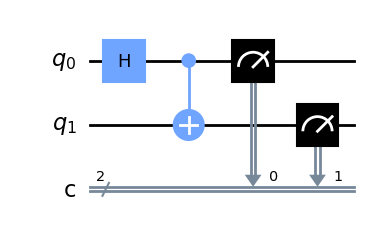

In [2]:
# Create a quantum circuit with 2 qubits and 2 classical bits
qc = QuantumCircuit(2, 2)

# Step 1: Apply Hadamard gate to the first qubit (qubit 0)
qc.h(0)

# Step 2: Apply CNOT gate with qubit 0 as control and qubit 1 as target
qc.cx(0, 1)

# Step 3: Measure both qubits
qc.measure([0, 1], [0, 1])

# Draw the circuit
qc.draw('mpl')

In [3]:
# Execute the circuit on the Aer simulator
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, backend=simulator, shots=1024)
result = job.result()

# Get the counts (measurement results)
counts = result.get_counts(qc)
print("Counts:", counts)

Counts: {'00': 506, '11': 518}


*Visualising Entanglement*

Statevector: Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2))


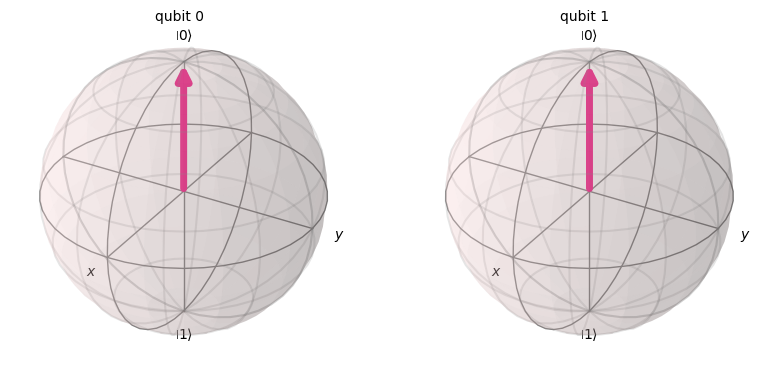

In [4]:
# Use the statevector simulator to get the quantum state
statevector_simulator = Aer.get_backend('statevector_simulator')
job = execute(qc, backend=statevector_simulator)
result = job.result()

# Get the statevector from the result
statevector = result.get_statevector()
print("Statevector:", statevector)

# Plot the Bloch multivector
plot_bloch_multivector(statevector)

*Implementing the CHSH Test in Qiskit*

In [5]:
# Function to measure in a given basis
def apply_measurement(qc, angle, qubit, classical_bit):
    # Apply a rotation around the Y-axis by the given angle
    qc.ry(2 * angle, qubit)
    qc.measure(qubit, classical_bit)

By default, measurement is in $Z$ basis. To test for violations of Bell's inequality (or more generally, to measure in different bases), we need to measure the qubits in different directions on the Bloch sphere, not just along the $Z$-axis.

The key point is that by applying the $2 \times \text{angle}$ rotation, we are effectively changing which axis of the Bloch sphere represents our "measurement axis." After rotating, a measurement in the $Z$-basis will correspond to a measurement in the rotated basis of the original state.

The $2\times$ is required because the gate is:
$$Ry\left(\theta \right)=\begin{pmatrix}\cos \left(\frac{\theta }{2}\right)&-\sin \left(\frac{\theta }{2}\right)\\ \sin \left(\frac{\theta }{2}\right)&\cos \left(\frac{\theta }{2}\right)\end{pmatrix}$$

In [6]:
# Function to run the CHSH test for different measurement settings
def run_chsh_test(angle_a, angle_b):
    # Create a quantum circuit with 2 qubits and 2 classical bits
    qc = QuantumCircuit(2, 2)
    
    # Step 1: Create a Bell state
    qc.h(0)
    qc.cx(0, 1)
    
    # Step 2: Apply the measurement angles
    apply_measurement(qc, angle_a, 0, 0)  # Apply measurement for qubit A
    apply_measurement(qc, angle_b, 1, 1)  # Apply measurement for qubit B
    
    # Execute the circuit
    simulator = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend=simulator, shots=1024)
    result = job.result()
    
    # Get the counts
    counts = result.get_counts(qc)
    return counts

In [7]:
# Function to calculate expectation value E(a, b) from the counts
def calculate_expectation(counts):
    total_counts = sum(counts.values())
    expectation = 0
    
    # Calculate the expectation value from the counts
    for outcome, count in counts.items():
        bit0, bit1 = int(outcome[0]), int(outcome[1])
        parity = (-1) ** (bit0 ^ bit1)  # Calculate parity for the outcome
        expectation += parity * (count / total_counts)
    
    return expectation

In the CHSH experiment, the goal is to measure the correlation between two qubits for different pairs of measurement settings (angles $a$ and $b$). The function `calculate_expectation` computes the expectation value $E(a,b)$ based on the results of these measurements. This expectation value captures how often the measurements of the two qubits agree or disagree when measured with settings $a$ and $b$.

$E(a,b)$ is $+1$ when correlated, $-1$ when anti-correlated.

Extracting `bit0` and `bit1`:

- The outcome is a string like `'00'`, `'01'`, `'10'`, or `'11'`.
- `bit0` corresponds to the measured result for qubit A, and `bit1` corresponds to the measured result for qubit B.

`bit0 ^ bit1` is the bitwise XOR operation. It compares `bit0` and `bit1`:
- If `bit0` and `bit1` are the same (both 0 or both 1), then `bit0 ^ bit1 = 0`.
- If `bit0` and `bit1` are different (one is 0, the other is 1), then `bit0 ^ bit1 = 1`.

The line `(-1) ** (bit0 ^ bit1)` gives:
- $+1$ when `bit0 ^ bit1 = 0` (i.e., `bit0` and `bit1` are the same, meaning the outcomes are correlated)
- $-1$ when `bit0 ^ bit1 = 1` (i.e., `bit0` and `bit1` are different, meaning the outcomes are anti-correlated)

For clarification, the line `parity = (-1) ** (bit0 ^ bit1)` effectively compares the results of Qubit 1 and Qubit 0. In the outcome `'01'`, `bit0 = 0` refers to Qubit 1's measurement result, and `bit1 = 1` refers to Qubit 0's measurement result.

In [10]:
# Define the measurement angles in radians
a = 0
a_prime = np.pi / 4
b = np.pi / 8
b_prime = -np.pi / 8

# Run the CHSH test for each combination of measurement settings
E_ab = calculate_expectation(run_chsh_test(a, b))
E_ab_prime = calculate_expectation(run_chsh_test(a, b_prime))
E_a_prime_b = calculate_expectation(run_chsh_test(a_prime, b))
E_a_prime_b_prime = calculate_expectation(run_chsh_test(a_prime, b_prime))

# Calculate the CHSH value S
S = E_ab + E_ab_prime + E_a_prime_b - E_a_prime_b_prime
print(f"The CHSH value is: S = {S}")

# Check if the inequality is violated
if abs(S) > 2:
    print("Bell's inequality is violated! This system exhibits quantum entanglement.")
else:
    print("Bell's inequality is NOT violated. This system behaves classically.")

The CHSH value is: S = 2.83203125
Bell's inequality is violated! This system exhibits quantum entanglement.


- $a=0$ is standard $Z$ basis measurement.
- $a'=\pi/4$ is standard $X$ basis measurement. 
- $b,b'$ are some rotated bases.

*Now, calculating the theoretical max violation, from statevectors.*

In [11]:
from qiskit.quantum_info import Statevector

# Define the Pauli matrices
pauli_x = np.array([[0, 1], [1, 0]])
pauli_z = np.array([[1, 0], [0, -1]])

# Function to calculate the expectation value of a given operator
def calculate_expectation(statevector, operator):
    # Convert the statevector to a NumPy array
    statevector_np = statevector.data.reshape(-1, 1)  # Convert to a column vector
    # Calculate the expectation value: <psi|A|psi>
    expectation_value = np.conj(statevector_np.T) @ operator @ statevector_np
    return np.real(expectation_value[0, 0])

# Create the Bell state |Φ+⟩
qc = QuantumCircuit(2)
qc.h(0)     # Apply Hadamard gate to qubit 0
qc.cx(0, 1) # Apply CNOT gate with qubit 0 as control and qubit 1 as target

# Get the statevector from the simulator
statevector_simulator = Aer.get_backend('statevector_simulator')
job = execute(qc, backend=statevector_simulator)
result = job.result()
statevector = Statevector(result.get_statevector(qc))

# Correctly define the rotation matrices for measurement settings
def measurement_operator(angle):
    return np.cos(angle) * pauli_z + np.sin(angle) * pauli_x

# Define the measurement settings
angles_a = [0, np.pi/2]  # a and a'
angles_b = [np.pi/4, -np.pi/4]  # b and b'

# Calculate expectation values for each combination
E_ab = calculate_expectation(statevector, np.kron(measurement_operator(angles_a[0]), measurement_operator(angles_b[0])))
E_ab_prime = calculate_expectation(statevector, np.kron(measurement_operator(angles_a[0]), measurement_operator(angles_b[1])))
E_a_prime_b = calculate_expectation(statevector, np.kron(measurement_operator(angles_a[1]), measurement_operator(angles_b[0])))
E_a_prime_b_prime = calculate_expectation(statevector, np.kron(measurement_operator(angles_a[1]), measurement_operator(angles_b[1])))

# Calculate the CHSH parameter S
S = E_ab + E_ab_prime + E_a_prime_b - E_a_prime_b_prime
print(f"The calculated CHSH value is: S = {S}")

The calculated CHSH value is: S = 2.8284271247461907


The measurement operator is:
$$A\left(\theta \right)=\cos \left(\theta \right)\sigma _z+\sin \left(\theta \right)\sigma _x$$

Hence the angles we considered have now been doubled, as we don't deal with the $\theta/2$ anymore.

*Finally, measuring the Bell state in the X-basis*

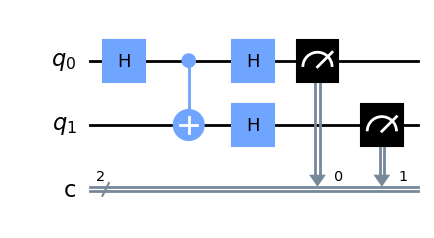

In [12]:
# Create a quantum circuit with 2 qubits and 2 classical bits
qc = QuantumCircuit(2, 2)

# Create the Bell state |Φ+⟩
qc.h(0)     # Apply Hadamard gate to qubit 0
qc.cx(0, 1) # Apply CNOT gate with qubit 0 as control and qubit 1 as target

# Apply Hadamard gates to both qubits to switch to the X-basis
qc.h(0)
qc.h(1)

# Measure both qubits
qc.measure([0, 1], [0, 1])

# Draw the circuit
qc.draw('mpl')

In [16]:
# Execute the circuit using the Aer simulator backend
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, backend=simulator, shots=1024)
result = job.result()

# Get the counts (measurement results)
counts = result.get_counts(qc)
print("Counts:", counts)

Counts: {'11': 497, '00': 527}


*Alternatively with Ry rotation, although equivalent*

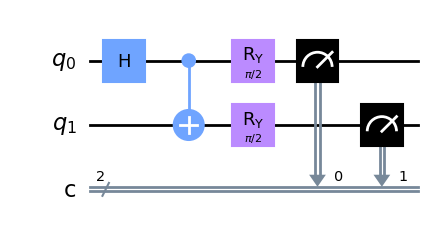

In [21]:
# Create a quantum circuit with 2 qubits and 2 classical bits
qc = QuantumCircuit(2, 2)

# Create the Bell state |Φ+⟩
qc.h(0)     # Apply Hadamard gate to qubit 0
qc.cx(0, 1) # Apply CNOT gate with qubit 0 as control and qubit 1 as target

# Function to measure in a given basis
def apply_measurement(qc, angle, qubit, classical_bit):
    # Apply a rotation around the Y-axis by the given angle
    qc.ry(2 * angle, qubit)
    qc.measure(qubit, classical_bit)

# Apply the measurement in the X-basis
apply_measurement(qc, np.pi / 4, 0, 0)  # Measure Qubit 0 in the X-basis
apply_measurement(qc, np.pi / 4, 1, 1)  # Measure Qubit 1 in the X-basis

# Draw the circuit
qc.draw('mpl')

In [23]:
# Execute the circuit using the Aer simulator backend
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, backend=simulator, shots=1024)
result = job.result()

# Get the counts (measurement results)
counts = result.get_counts(qc)
print("Counts:", counts)

Counts: {'11': 523, '00': 501}


The outcomes `00` correspond to measuring both qubits in the $|+\rangle$

The outcomes `11` correspond to measuring both qubits in the $|-\rangle$